# ASTR 21100 

# "Computational Techniques in Astrophysics"

## Instructor: Andrey Kravtsov

### office: ERC 415; email: kravtsov@uchicago.edu
### office hours: Tue, 10:30am-noon (unless noted otherwise)

#### Teaching Assistants: 
#### Dimitrios Tanoglidis (dtanoglidis@uchicaago.edu)
#### Georgios Zakharegkas (gzakharegkas@uchicago.edu)

In [1]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline
# reusing my codes from the repository
from codes.plot_utils import plot_pretty
plot_pretty(dpi=150, fontsize=12)

In [2]:
plot_pretty(dpi=150, fontsize=12)

## Pseudo-random number generators (PRNGs)

"*Anyone who attempts to generate random numbers by deterministic means is, of course, living in a state of sin.*"  - <a href="https://en.wikipedia.org/wiki/John_von_Neumann">John von Neumann</a>

<center><img width=400 src="img/John_von_Neumann-LosAlamos.gif"></img></center>


<a href="https://en.wikipedia.org/wiki/John_von_Neumann">John von Neumann</a> is a Hungarian born American mathematician, who made important contributions in quantum physics, logic, meteorology, computational methods, and computer science and to the Los Alamost project during WWII.

### "Truly" uniform random number sequences

<a href="http://www.fourmilab.ch/hotbits/">HotBits</a> generates random numbers using inherent uncertainty of quantum systems by using Geiger counter counts of radiactive source, while <a href="https://www.random.org/">random.org</a> uses atmospheric radio noise to produce random numbers. 

You can use these services to get truly random  sequences. However, this is essentially almost never needed in practice, as periods and statistical properties of good modern pseudo random number generators are extremely large and are sufficient for all practical purposes.

Plus, using these sequences also has its own set of issues related to some existing correlations of generated random numbers. Also, a practical issue is that it's very difficult to generate very large sequences of random numbers this way. 

### Pseudo-Random Number Generators (PRNGs)

A generic PRNG algorithm consists of a function that operates on a series of previous random values in the sequence to get the next value: 

$$
x_{n+1} = \mathrm{PRNG}(x_n, x_{n-1}, x_{n-2},\ldots, x_{n-l+1}),
$$

where $l$ is called the *lag* of the algorithm. $x_i$'s are almost always integers with a given number of bits (e.g., 32 or 64) and a PRNG are designed to uniformly and uniquely draw every (or nearly every) integer number from 0 to some number $m$, which is called period. 

So, how can we even use the word "random" in pseudo-random number generators without blushing???

The way to think about it is by analogy with *artificial intelligence*. The famous <a href="https://www.turing.org.uk/scrapbook/test.html">Turing test</a> posits that we've created artificial intelligence if a person can have a conversation with a computer without realizing that he is not talking to a human. If a code produces output in response to input (or even lack thereof) that is distinguishable from what a sentient human being would produce, it qualifies as intelligence! 

Likewise, "randomness" of the PRNG should be judged by the ability of someone to tell whether the sequence of numbers is random or not without knowing how the sequence was obtained. If there is no test that shows that data is not random, then it is effectively random, even if it was produced by a deterministic algorithm/code. 

For scientific applications this is the only criterion that matters. For applications in cryptography there are additional criteria for a good PRNG. The main one that it should be very difficult (or close to impossible) to reverse engineer the algorithm used to produce a sequence of pseudo-random numbers. 

For some scientific and cryptography applications speed and ability to produce very long sequences of pseudo-random numbers with good "randomness" properties is also a big factor.

### Linear congruential PRNGs

Historically, *linear-congruential* PRNG algorithms were popular in early applications due to their simplicity, speed, and low memory requirements. 

By the Kronecker-Weyl theorem all possible numbers from 0 to $m$ can be generated via the recursion formula, 

$$x_{n+1}=(ax_n+c)\, \mathrm{mod}\, m$$

where $x_0$ is the seed. Generators with $a>0$ and $c=0$ are called multiplicative congruential generators (MCGs). 

Here $\mathrm{mod}\, m$ is the <a href="https://en.wikipedia.org/wiki/Modulo_operation">modulo operation</a> (remainder of the integer division by $m$, operator % in python) and $m$ is intended period of the sequence. This means that sequence repeats itself after $m$ numbers. 

Parameters $a$, $c$, and $m$ are chosen carefully to produce the most random sequences for the required sequence length (size). Period $m$ will also define how many bits we will need to store the integer numbers in the sequence. 

In [3]:
print(1%9)

1


In [4]:
def lcg(a=16807, c=0, m=2**32):
    """
    Linear Congruential Generator
    
    default parameters above correspond to what's known to be the Lehmer minimal RNG
    
    Parameters:
    -----------
    
    a: integer > 0 
        multiplicative constant of LCG
        
    c: integer > 0 
        additive constant of LCG
    m: integer > 0 
        period of LCG
            
    Returns: 
    --------
    integer of the same length as the previous number
    (next number in the LCG sequence of pseudo-random numbers)
    """
    assert(a>0); assert(c>=0); assert(m>0);

    lcg.current = (a * lcg.current + c) % m
    return lcg.current

In [5]:
lcg.current = 392382 # seed

dummy = lcg()
print(dummy)
print("number of bits = %d"%len(bin(dummy)[2:]))

Nrnd = 10
for i in range(Nrnd):
    dummy = lcg()
    print("%d"%(dummy))

2299796978
number of bits = 32
2277112542
3271886034
2122282750
3797753266
1330155806
623855762
1128622398
2181064050
3892584286
1722242130


### A given number in the LCG sequence can actually be predicted from any previous number in the sequence

The linear recursion relation defining LCG 
$$r_{n+i} =\left[a^i r_n + \frac{c(a^i-1)}{a-1}\right]\,\mathrm{mod}\, m.$$

This allows us to vectorize generation of many numbers at once.

In [6]:
def lcg_vector(seed = None, nrnd=100, a=16807, c=0, m=2**32):
    """
    vectorized Linear Congruential Generator
    
    default parameters above correspond to what's known to be the Lehmer minimal RNG
    
    Parameters:
    -----------
    
    seed: integer > 0
            seed for the LCG sequence
    nrnd: integer > 0 
            number of integer numbers to generate   
    a: integer > 0 
        multiplicative constant of LCG        
    c: integer > 0 
        additive constant of LCG
    m: integer > 0 
        period of LCG
            
    Returns: 
    --------
    a numpy vector of nrnd integers 
        random integers generated from input seed with input parameters a, c, m

    """
    assert(a>0); assert(c>=0); assert(m>0);
    
    i = np.arange(1, nrnd, 1)
    ai = np.power(a,i)
    return (ai * seed + c*(ai-1)/(a-1)) % m

In [7]:
# compare non-vectorized and vectorized versions of LCG
nrnd = 10
seed = 3374363
rv = lcg_vector(seed=seed, nrnd=nrnd)

lcg.current = seed
for i in range(nrnd-1):
    print("%d   %d"%(rv[i], lcg()))

878344093   878344093
526574699   526574699
2508336333   2508336333
2504738491   2504738491
2165350141   2165350141
1781920779   1781920779
4230544941   4230544941
3880205403   3880205403
4123753053   4123753053


In [8]:
# how fast are these?
nrnd = 1000000
%timeit for i in range(nrnd): lcg()

388 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit lcg_vector(seed=seed, nrnd=nrnd)

65.5 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit np.random.randint(low=0, high=2**31, size=nrnd)

4.5 ms ± 306 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Turning integer sequence into sequence of floats in the range [0,1)

To do this, just divide the LCG sequence by its period $m$ using floating point arithmetic:

In [14]:
nrnd = 9999 # nrnd here is chosen so that it divides into 2 equal-size subsumples for ploting below
period = 2**21
rv = 1.*lcg_vector(seed=seed, nrnd=nrnd, m=period) / period

### Qualitative check of randomness of the generated sequence using a "randogram"

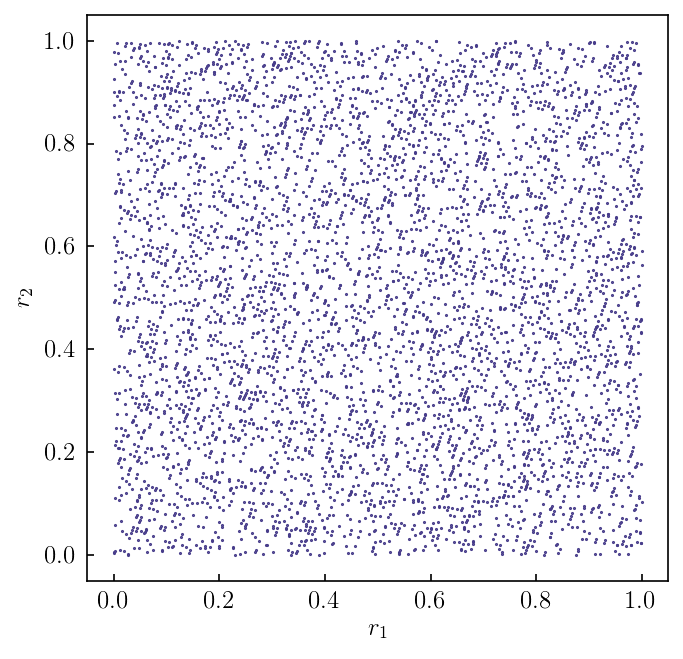

In [16]:
fig = plt.figure(figsize=(5, 5))
plt.xlabel(r'$r_1$')
plt.ylabel(r'$r_2$')
# plot even elements of the array against odd elements
plt.scatter(rv[::2], rv[1::2], marker='.', s=1., c='darkslateblue')
plt.show()  

In [18]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

def plot_rnd_3d(rv):
    """
    plot triples of input numbers in 3d interpreting them
    as 3D coordinates of points
    
    assumes that rv element values are in [0,1]
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    lims = [0.,1.]
    ax.set_xlim(lims); 
    ax.set_ylim(lims); 
    ax.set_zlim(lims)

    # select triples using array slicing
    ax.scatter(rv[::3], rv[1::3], rv[2::3], 
               c='darkslateblue', marker='.', s=2)

    plt.show()
    return

<IPython.core.display.Javascript object>


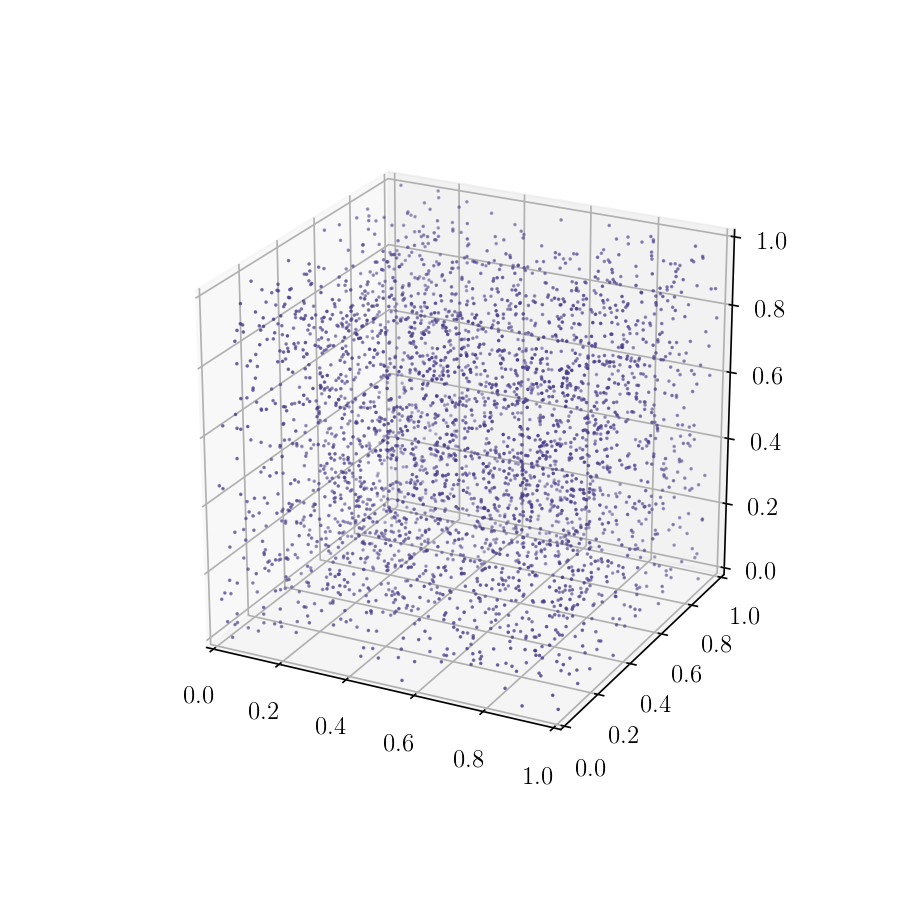

In [19]:
# this magic command tells matplotlib to produce inline plots with interactive capability (rather than just png file)
%matplotlib notebook

nrnd = 10000
period = 2**21
rv = 1.*lcg_vector(seed=seed, nrnd=nrnd, m=period) / period

# rv is split into 3 equal-size sequences that are used as 3D coordinates as points, which are displayed in 3D
plot_rnd_3d(rv)

### Performance of LCGs

is very sensitive to the choice of parameters $a$ and $c$. Bad choices can result in very bad results - for example, the infamous <a href="https://en.wikipedia.org/wiki/RANDU">RANDU</a> RNG, which has $a=65539$, $c=0$, $m=2^{31}$. 

These parameters were chosen for speed of execution because operations can be done by manipulating bits using low-level hardware operations. IBM was distributing RANDU as a default RNG on its computer systems, and it became widely used. Its horrible properties were not discovered until early 1970s and it took three additional decades to purge RANDU from use completely. 

<IPython.core.display.Javascript object>


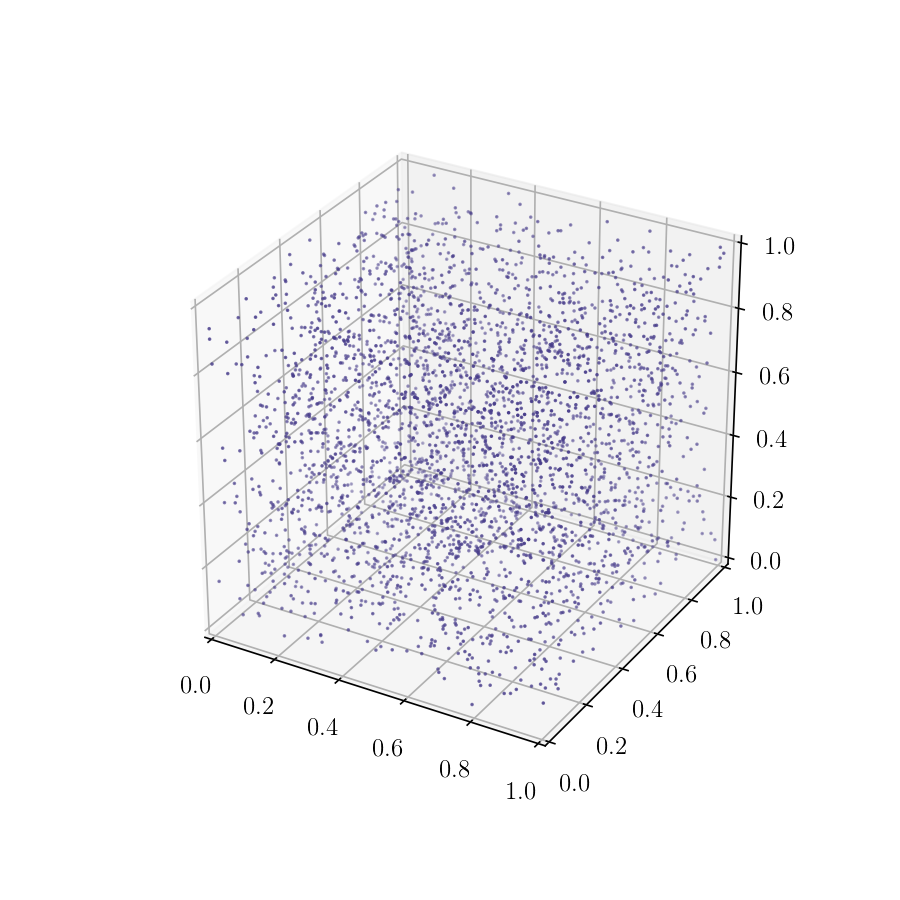

In [20]:
nrnd = 10000
period = 2**31

# the infamous RANDU RNG (don't try this at home!):
a = 65539
rv = 1.*lcg_vector(seed=seed, nrnd=nrnd, a=a, m=period) / period

plot_rnd_3d(rv)

This is because <a href="https://en.wikipedia.org/wiki/RANDU#Problems_with_multiplier_and_modulus">it can be easily shown</a> that for this choice, the three subsequent generated numbers are related by

$$r_{i+2}=6r_{i+1}-9r_i,$$

which defines a 3D plane. This is why planes appear in the above example when we use triples of subsequent generated numbers as coordinates in 3D space. 

Generally, <a href="http://adsabs.harvard.edu/abs/1968PNAS...61...25M">Marsaglia (1968)</a> showed that using LCG to choose points in an 
$n$-dimensional space will
generate points that will lie on, at most, $(d!m)^{1/d}$ $d$-dimensional hyperplanes.

"*all multiplicative congruential random number generators have a defect—a defect
that makes them unsuitable for many Monte Carlo problems and that cannot be
removed by adjusting the starting value, multiplier, or modulus. The problem lies
in the “crystalline” nature of multiplicative generators—if n-tuples $(u_1,u_2,...,u_n)$,
$(u_2,u_3,...,u_{n+1})$ of uniform variates produced by the generator are viewed as points
in the unit cube of n dimensions, then all the points will be found to lie in a relatively
small number of parallel hyperplanes. Furthermore, there are many systems of
parallel hyperplanes which contain all of the points; the points are about as randomly
spaced in the unit n-cube as the atoms in a perfect crystal at absolute zero.*"

### Specific bit-wise manifestation of LCG-generated integers

Strong correlations of integer numbers that are near each other in a LCG-generated sequence has a very specific manifestation in the bit-level representations of these integers. 

Examine the following binary form of the LCG output (decent choice of $a$ here, not RANDU) and see if you notice any regularities.

In [25]:
Nrnd = 10
for i in range(Nrnd):
    dummy = lcg()
    # print bits, excluding the first special and sign bits
    print("binary form: %32s"%(bin(dummy)[2:]))

binary form: 10000010001111101100011111101011
binary form: 11100111101101110001010101001101
binary form: 10100100110101110111001000111011
binary form:   111100100011000111111101111101
binary form:   101100000001011110011110001011
binary form:   110111101001000101011010101101
binary form:      110001101100111011111011011
binary form: 11100001111101101100101011011101
binary form:    10001100000000111001100101011
binary form:     1000000010010000110000001101


* lowest (rightmost) 2 bits do not change at all!

* 3rd bits from the right flip back and forth between 0 and 1 in subsequent numbers. 4th bit does not change. 5th bit varies in a distinct pattern.

* The behavior of higher bits becomes progressively less regular, so higher bits are more random than lower ones. 

### Permuted Congruential Generators (PCGs)

Professor <a href="https://www.cs.hmc.edu/~oneill/index.html">Melissa O'Neill</a> of Harvey Mudd college proposed a powerful, yet simple way to fix the well-understood flaws of LCGs in 2014. 
The idea is to permute (or scramble) bits of the integer numbers that are generated by LCG using a permutation function. 

For example, a bitwise <a href="http://mathworld.wolfram.com/XOR.html"><tt>xor</tt> operation</a> (done by ^ operator in python) of a set of bits with another set of bits of the same size is a permutation function: it flips some bits in its target and changes the overall distribution of 1's and 0's in the bit set. 

Another similar permutation called **xorshift** is to shift bits to the right or left by some number of positions (operations << and >> in python) and then xor the result with another number.

In [31]:
print("illustration of a xor operation:")
i1, i2 = 98293489442, 99278249448
print(bin(i1)[2:])
print(bin(i2)[2:])
print ("    %s"%bin(i1 ^ i2)[2:])
print('-----------------------------------')
print("illustration of a right xorshift operation:")
print("   %s"%bin(i1 >> 3)[2:])
print(bin(i2)[2:])
print ("%s"%bin((i1 >> 3) ^ i2)[2:])

illustration of a xor operation:
1011011100010101111111001111100100010
1011100011101011100011101110111101000
    111111111110011100100001011001010
-----------------------------------
illustration of a right xorshift operation:
   1011011100010101111111001111100100
1011100011101011100011101110111101000
1010111000001001001100010111000001100


### PCG family of generators

Different PCG variants can be designed by choosing different permutation functions. We will consider an implementation of <tt>RXS_M_XS</tt> permutation function described in Section 6.3.4 (p. 38) of M. O'Neill's 2014 <a href="http://www.pcg-random.org/paper.html">paper</a>.

This permutation function decomposes bits of an integer number into three groups and consists of three steps:

1. "random xorshift" operation. This operation uses the three highest (leftmost) bits of the number to choose how much of bit shift to the right to apply and are also used in the xorshift itself. This randomizes middle bits of the number.

2. Multiplication by a suitably chosen integer. This randomizes the upper bits of the number. 

3. xorshift that xors the upper third bits of the number with the lower third bits of the number. 

This particular permutation choice generates an invertable (i.e. insecure for cryptography applications) pseudo-random sequence. Thus, it is no good for encryption use, but fine for science (other choices can be made to produce secure sequences). This sequence has fantastic randomness qualities and its 64-bit version passes all of the major test suites of RNGs. See, for example, Figures 15 and 16 in M. O'Neill's 
<a href="http://www.pcg-random.org/paper.html">paper</a>, as well as additional test results <a href="https://www.johndcook.com/blog/2017/08/14/testing-rngs-with-practrand/">here</a>. 

In [35]:
u4 = np.uint32(4)
u22 = np.uint32(22)
u28 = np.uint32(28)
u277803737 = np.uint32(277803737)

def permute_bits_rxs_m_xs_32_32(rnd) :  
    """
    a function performing permutation of bits in a 32-bit integer
    based on rxs_m_xs_32_32 implementation 
    by Prof. Melissa O'Neill
    http://www.pcg-random.org/download.html

    Parameters:
    -----------
    a 1d vector of 32-bit integers
    
    Returns:
    --------
    
    a 1d vector of 32-bit integers with bits scrambled by 
    the rxs_m_xs_32_32 permutation function, 
    see Sections 6.3.4 and 5.5.1 in M. O'Neill's paper
    """
    # first 2 steps: random xorshift and multiplication
    # shift bits in 32-bit number by 28 to the left, which leaves 3 upper bits
    # then add 4 to the results and shift the bits in a number by that result 
    # to the right, finally xor result with the number itself
    # then multiply by a good large number to randomize top bits
    rnd = np.uint32(rnd)
    rndd = np.uint32((rnd >> ((rnd >> u28) + u4)) ^ rnd) * u277803737;
    # third step: shift bits resulting from first 2 steps 
    # by 22 positions to the right and xor result with the result of step 2
    return (rndd >> u22) ^ rndd;

In [36]:
u5 = np.uint64(5)
u43 = np.uint64(43)
u59 = np.uint64(59)
u12605985483714917081 = np.uint64(12605985483714917081)

def permute_bits_rxs_m_xs_64_64(rnd) :  
    """
    a function performing permutation of bits in a 64-bit integer
    based on rxs_m_xs_64_64 implementation 
    by Prof. Melissa O'Neill
    http://www.pcg-random.org/download.html
    
    Parameters:
    -----------
    a 1d vector of 64-bit integers
    
    Returns:
    --------
    
    a 1d vector of 64-bit integers with bits scrambled by 
    the rxs_m_xs_64_64 permutation function, 
    see Sections 6.3.4 and 5.5.1 in M. O'Neill's paper
    """
    rnd = np.uint64(rnd)
    # similar steps to the above 32-bit version but using different
    # numbers appropriate for the 64 bit case
    rndd = np.uint64((rnd >> ((rnd >> u59) + u5)) ^ rnd) * u12605985483714917081;
    return (rndd >> u43) ^ rndd;

In [37]:
seed = 392382

# permute bits of RANDU generated numbers
nrnd = 10000
period = 2**31

# the infamous RANDU RNG:
a = 65539
rv = lcg_vector(seed=seed, nrnd=nrnd, a=a, m=period)

# about to be much improved by additional scrambling of bits in numbers it generated
rvp32 = permute_bits_rxs_m_xs_32_32(rv) 

# turn resulting integers into integers within [0,period]
rvp = rvp32 % period 
# turn integers into floats in range [0,1]
rvf = 1.* rvp / period

In [38]:
print("min and max values of generated numbers: %.6g   %.6g"%(np.min(rvf), np.max(rvf)))

min and max values of generated numbers: 0.00019461   0.999889


<IPython.core.display.Javascript object>


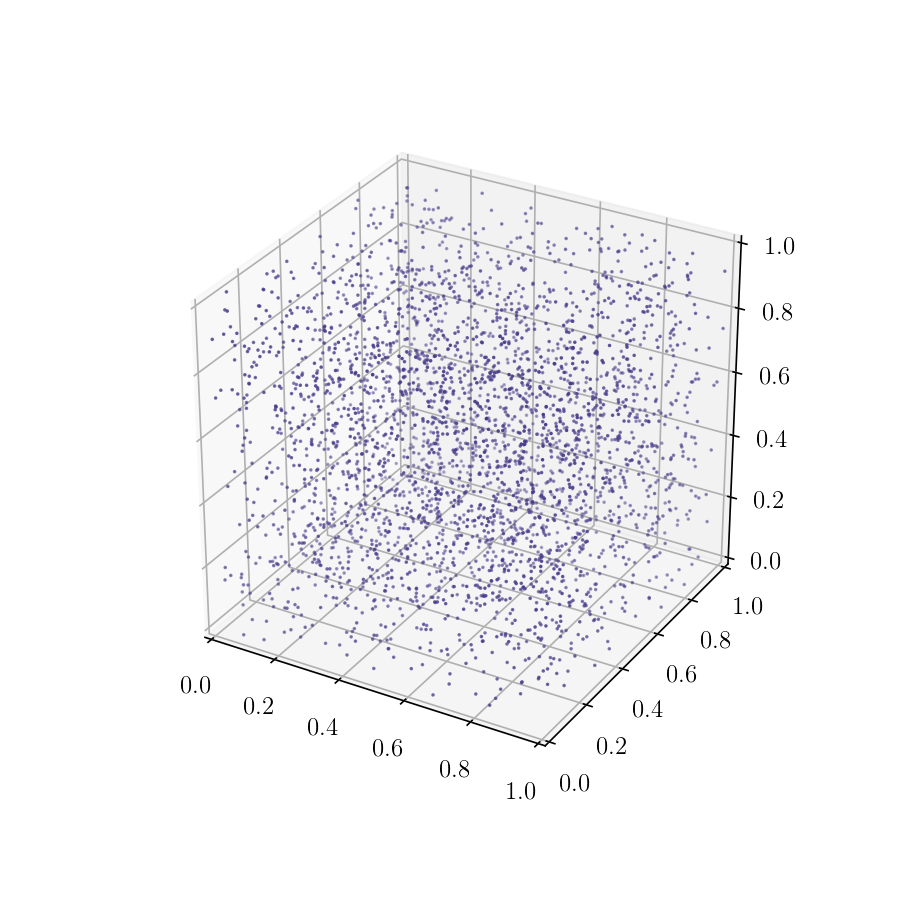

In [39]:
plot_rnd_3d(rvf)

Examining the 3D distribution generated by the RANDU LCG, but with integer number bits scrambled using <tt>RXS_M_XS</tt> permutation function, we can see that random numbers are no longer confined on planes and appear to be uniformly distributed. 

Let's take a look at the bits of the generated numbers after the permutation.

In [40]:
Nrnd = 10 
for dummy in rvp[:Nrnd]:
    print("binary form: %32s"%(bin(dummy)[2:]))

binary form:  1100111011111100000011010111001
binary form:  1101100000110101000101011010110
binary form:  1001010001111110101100100110010
binary form:  1010010010010110000010100000111
binary form:  1110100000000011101111100101110
binary form:  1011000101100100100001010001100
binary form:   100110011010010001111101000000
binary form:  1001100011101011001001011001111
binary form:  1010100000000100000000010101000
binary form:  1101001010010001010111010011000


We can see that the lower (rightmost) bits no longer have the strongly manifested regularities we say for the raw numbers produced by LCG. In fact, we'd be hard pressed to find any regularity in any of the bits. So permutation has successfully randomized the bit pattern and the integers themselves. 

### Good choices of constants for LCGs

Even better results will be achieved if before permutation, we use optimal values of $a$, $c$ and $m$ that provide the best LCG sequences. Combinations of these are listed in the paper by <a href="http://www.ams.org/journals/mcom/1999-68-225/S0025-5718-99-00996-5/S0025-5718-99-00996-5.pdf">L'Ecuyer (1999)</a> (see Table 2 in that paper for values of $m$ and $a$, $c=0$ in all of the cases). 

For example, $m=2^{31}-1$ and $a=1583458089$ suitable for 32-bit LCG, while 
$m=2^{63}-25$ and $a=4645906587823291368$ can be used for a 64-bit LCG.

With such choices and using 64 or 128 bit versions of PCGs, PRNGs which <a href="https://www.johndcook.com/blog/2017/08/14/testing-rngs-with-practrand/">pass existing major tests</a> of PRNGs can be implemented. In fact, 64-bit PCGs pass tests that the fancy <a href="https://en.wikipedia.org/wiki/Mersenne_Twister">Mersenne Twister</a> generator - the *default in numpy* - fails. 

### Take-home messages

* It's not completely obvious (it took people ~60 years of research!), but PRNGs that are fast, simple (few lines of code), and have great statistical properties (i.e. very close to being truly random) can be implemented.


* With a clever algorithmic idea and a few lines of code we can beat a default numpy routine. 

### Recommended watching on PNRGs

To learn about history of pseudo random number generators and associated problems, as well as about PCG generators, you can watch video of an excellent colloquium by Melissa O'Neill at Stanford a few years ago: 

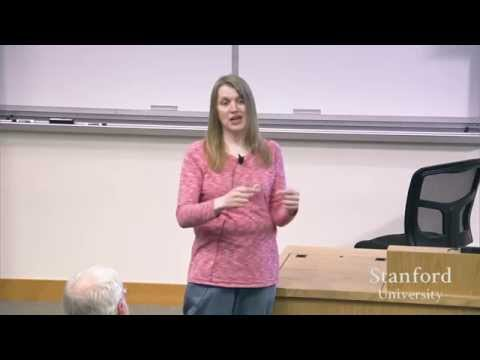

In [41]:
from IPython.display import YouTubeVideo  

YouTubeVideo("45Oet5qjlms", width=640, height=360)  